In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
dataset_path = "CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone" 

# Dataset Overview

Classes: ['Cyst', 'Normal', 'Stone', 'Tumor']
Number of classes: 4
Total images: 12446

Images per class:
Cyst: 3709
Normal: 5077
Stone: 1377
Tumor: 2283


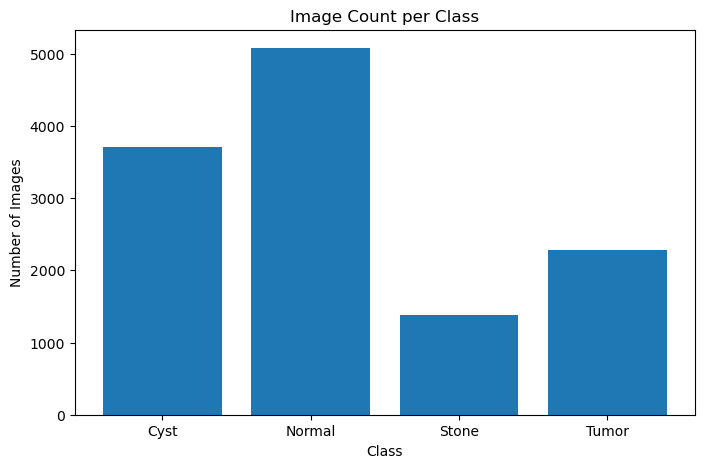

In [ ]:

class_names = []
image_counts = {}

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    
    if os.path.isdir(class_path):
        class_names.append(class_name)
        image_counts[class_name] = len(os.listdir(class_path))

print("Classes:", class_names)
print("Number of classes:", len(class_names))
print("Total images:", sum(image_counts.values()))
print("\nImages per class:")
for k, v in image_counts.items():
    print(f"{k}: {v}")


plt.figure(figsize=(8,5))
plt.bar(image_counts.keys(), image_counts.values())
plt.title("Image Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

This analysis shows that the dataset contain a  total of 12446 images and  4 classes on this dataset and these are  Normal, Cyst, Stone, Tumor. Normal class has the highest number of images and Stone class has the lowest number of images. The class distribution is imbalanced. This imbalance suggests that the model may become biased toward the Normal class during training.

In [ ]:
image_shapes = []

for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    
    for img_name in os.listdir(class_path)[:50]:
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            image_shapes.append(img.shape[:2])  

image_shapes = np.array(image_shapes)

print("Image Height - Min:", image_shapes[:,0].min(),
      "Max:", image_shapes[:,0].max())

print("Image Width  - Min:", image_shapes[:,1].min(),
      "Max:", image_shapes[:,1].max())


Image Height - Min: 512 Max: 1001
Image Width  - Min: 512 Max: 1236


This analysis indicates that the dataset contains different resolutions of images. Heights range from 512 to 1001 pixels and widths range from 512 to 1236 pixels. So maybe need to resizing or standardization.

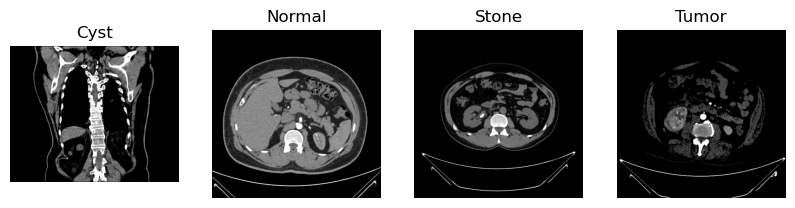

In [4]:
plt.figure(figsize=(10,6))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, len(class_names), i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.show()


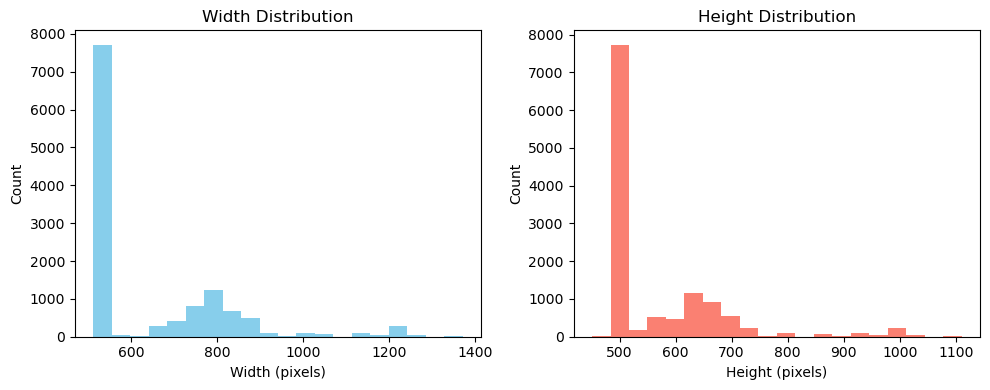

In [5]:
widths = []
heights = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        img_path = os.path.join(root, file)
        try:
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)
        except:
            continue  
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color='skyblue')
plt.title("Width Distribution")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color='salmon')
plt.title("Height Distribution")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


This analysis of image width and height exhibit a left-skewed pattern, indicating that most images are concentrated toward the lower pixel ranges, with a smaller number of images extending to larger dimensions. This variability in image dimensions confirms that the dataset does not have a uniform input size. So it maybe necessary to use resizing or standardizing

# Image Pixel size

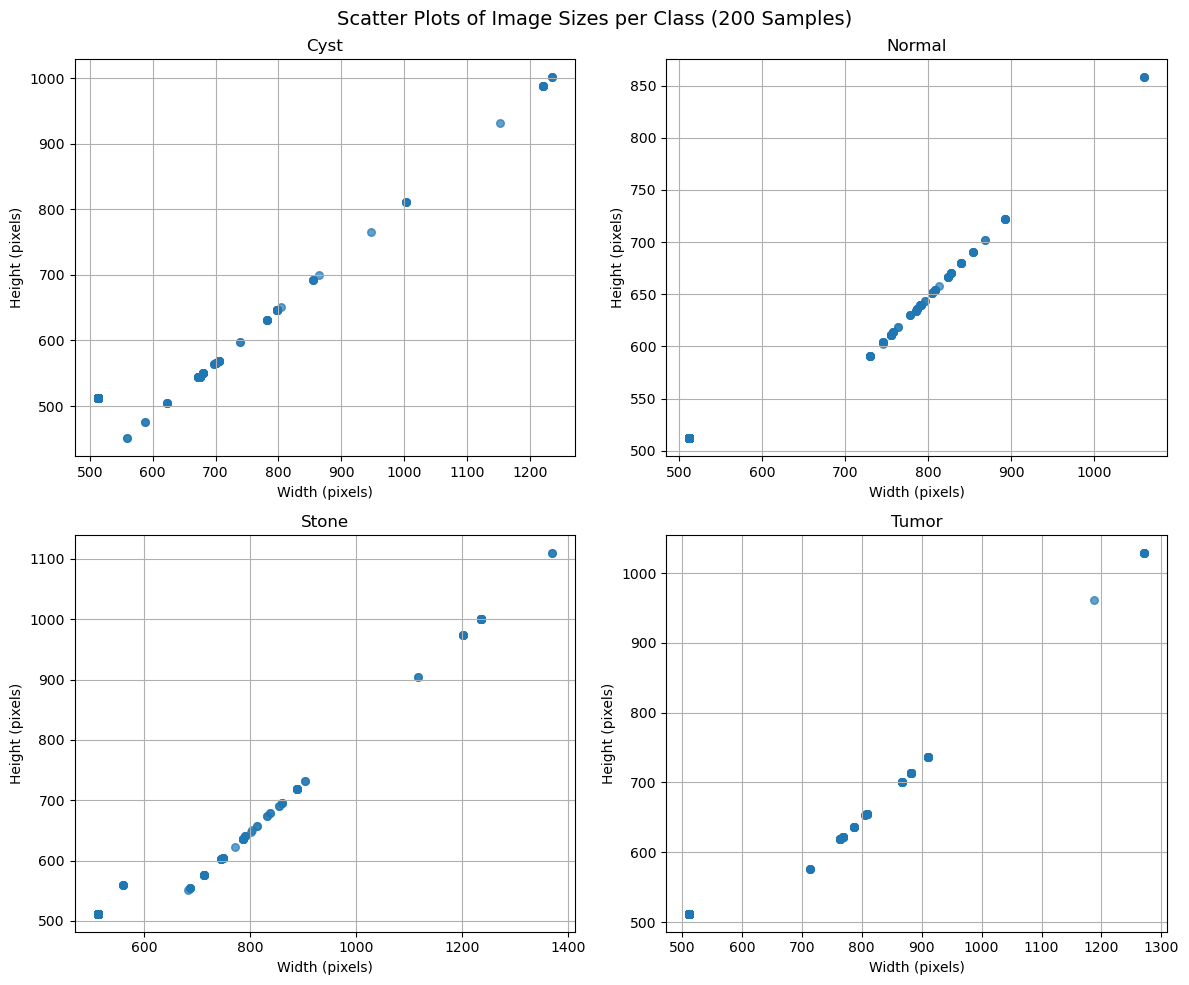

In [ ]:

TOTAL_SAMPLES = 1000

class_names = sorted(os.listdir(dataset_path))
num_classes = len(class_names)
samples_per_class = TOTAL_SAMPLES // num_classes


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    
    sampled_images = random.sample(images, min(samples_per_class, len(images)))
    
    widths = []
    heights = []

    for img_name in sampled_images:
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
        except:
            continue

    ax = axes[idx]
    ax.scatter(widths, heights, alpha=0.7, s=30)
    ax.set_title(class_name)
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")
    ax.grid(True)

plt.suptitle("Scatter Plots of Image Sizes per Class (1000 Samples)", fontsize=14)
plt.tight_layout()
plt.show()


This scatter plot presents the distribution of image widths and heights for the Cyst, Normal, Stone, and Tumor classes, showing how image resolutions vary across the dataset. Each point represents an individual image, and the overall diagonal patterns indicate that most images maintain consistent aspect ratios as size increases. The Normal class appears more tightly clustered, suggesting relatively uniform image dimensions, while the Cyst, Stone, and Tumor classes show greater variability and include some large-resolution outliers. This analysis highlights the non-uniformity of image sizes in the dataset and emphasizes the need for resizing and proper preprocessing before training convolutional neural network models.

# Pixel Statistics

### Mean

In [ ]:
def class_pixel_mean(class_path):
    means = []
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue   
        img = img.astype("float32")
        means.append(np.mean(img))
    return np.mean(means)

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        mean_value = class_pixel_mean(class_dir)
        print(f"Class: {class_name} → Pixel Mean: {mean_value:.2f}")

Class: Cyst → Pixel Mean: 26.45
Class: Normal → Pixel Mean: 44.66
Class: Stone → Pixel Mean: 35.40
Class: Tumor → Pixel Mean: 36.28


The average pixel intensities vary between classes, with Normal images having the highest mean (44.66) and Cyst images the lowest (26.45), suggesting that Normal images are generally brighter while Cyst images are darker.

### Std 

In [4]:
def class_pixel_std(class_path):
    std = []

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue   
        img = img.astype("float32")
        std.append(np.std(img))
    return np.mean(std)

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        std_value = class_pixel_std(class_dir)
        print(f"Class: {class_name} → Pixel std: {std_value:.2f}")

Class: Cyst → Pixel std: 49.13
Class: Normal → Pixel std: 65.17
Class: Stone → Pixel std: 55.01
Class: Tumor → Pixel std: 60.35


The standard deviation of pixel values, which reflects the contrast within images, ranges from 49.13 (Cyst) to 65.17 (Normal), indicating moderate variation in contrast across classes.

### Minimum and maximum 

In [6]:
def class_pixel_min_max(class_path):
    min=[]
    max=[]

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue   
        img = img.astype("float32")
        min.append(np.min(img))
        max.append(np.max(img))

    return np.mean(min),np.mean(max)

for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        min, max=  class_pixel_min_max(class_dir)
        print(f"Class: {class_name} → Min: {min:.2f}, Max: {max:.2f}")

Class: Cyst → Min: 0.00, Max: 255.00
Class: Normal → Min: 0.00, Max: 255.00
Class: Stone → Min: 0.00, Max: 255.00
Class: Tumor → Min: 0.00, Max: 255.00


The maximum and minimum values are 0 to 255 for every class, which means that images contain the complete spectrum from dark to bright pixel

# Pixel intensity 

### Cyst

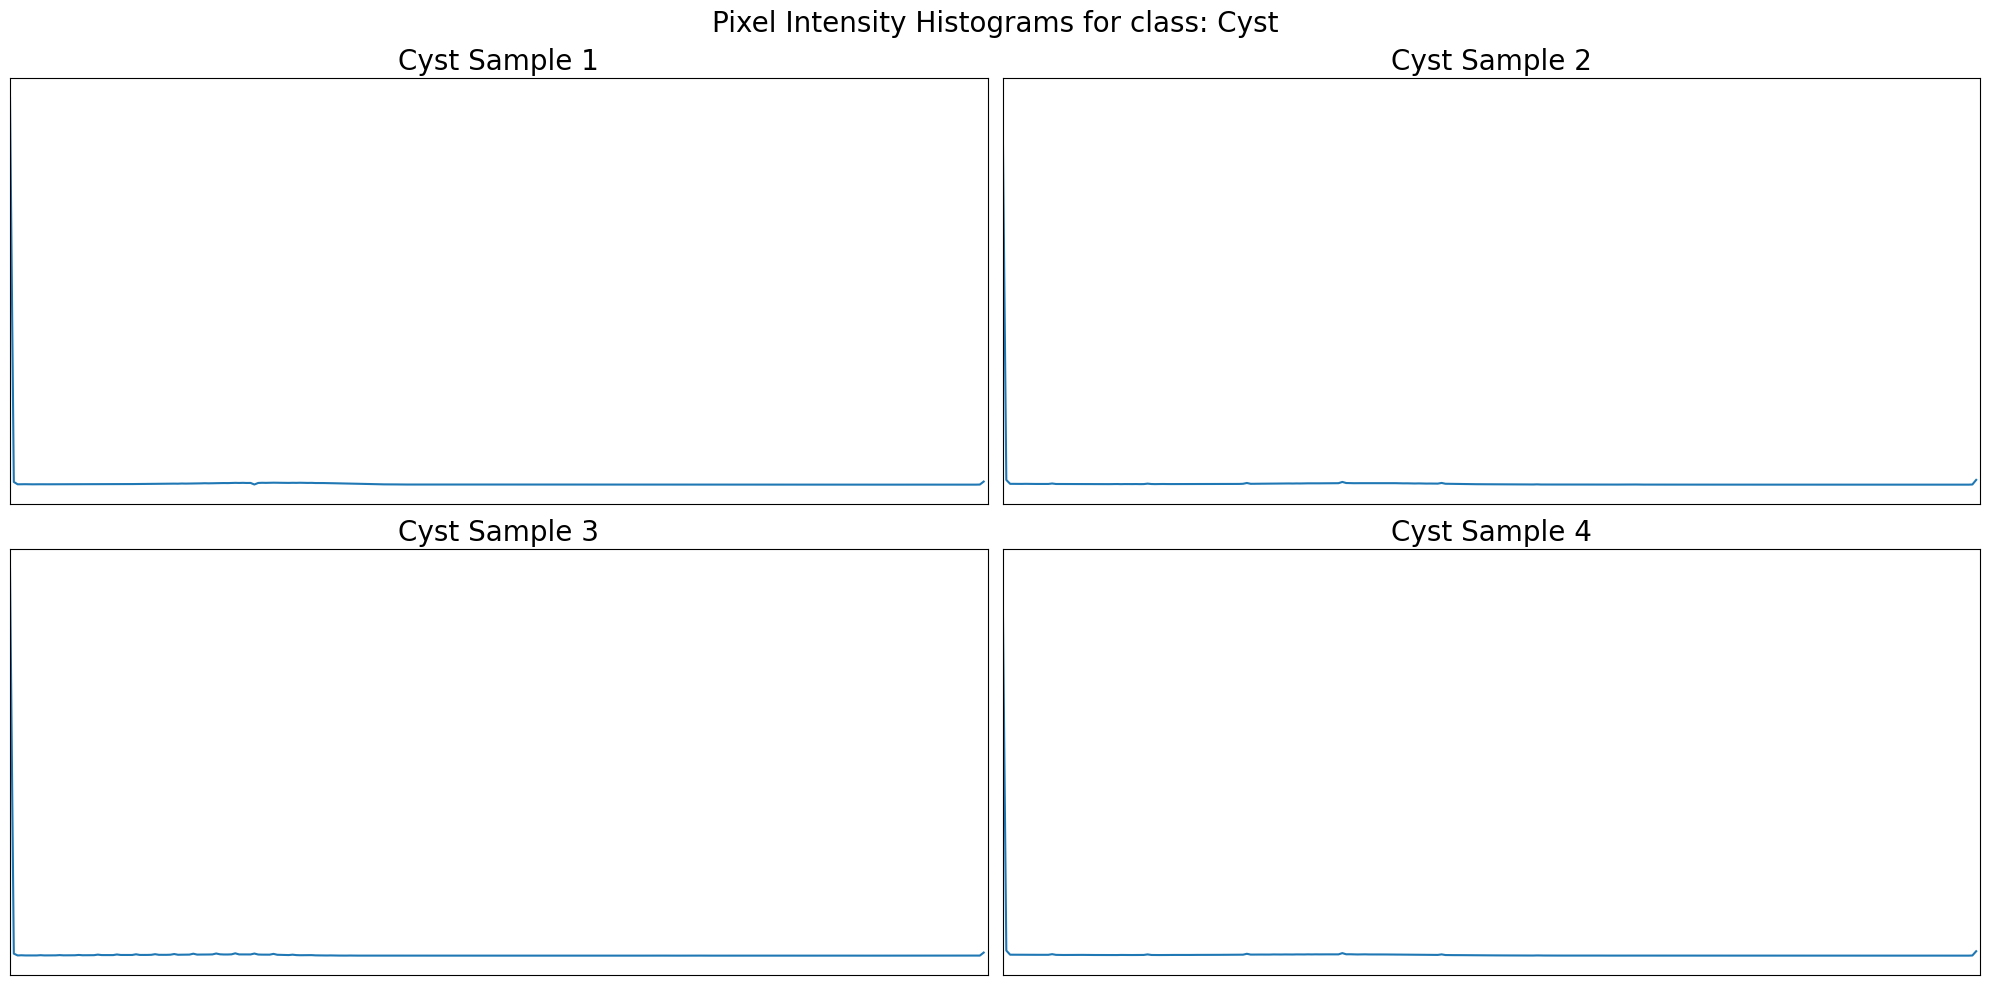

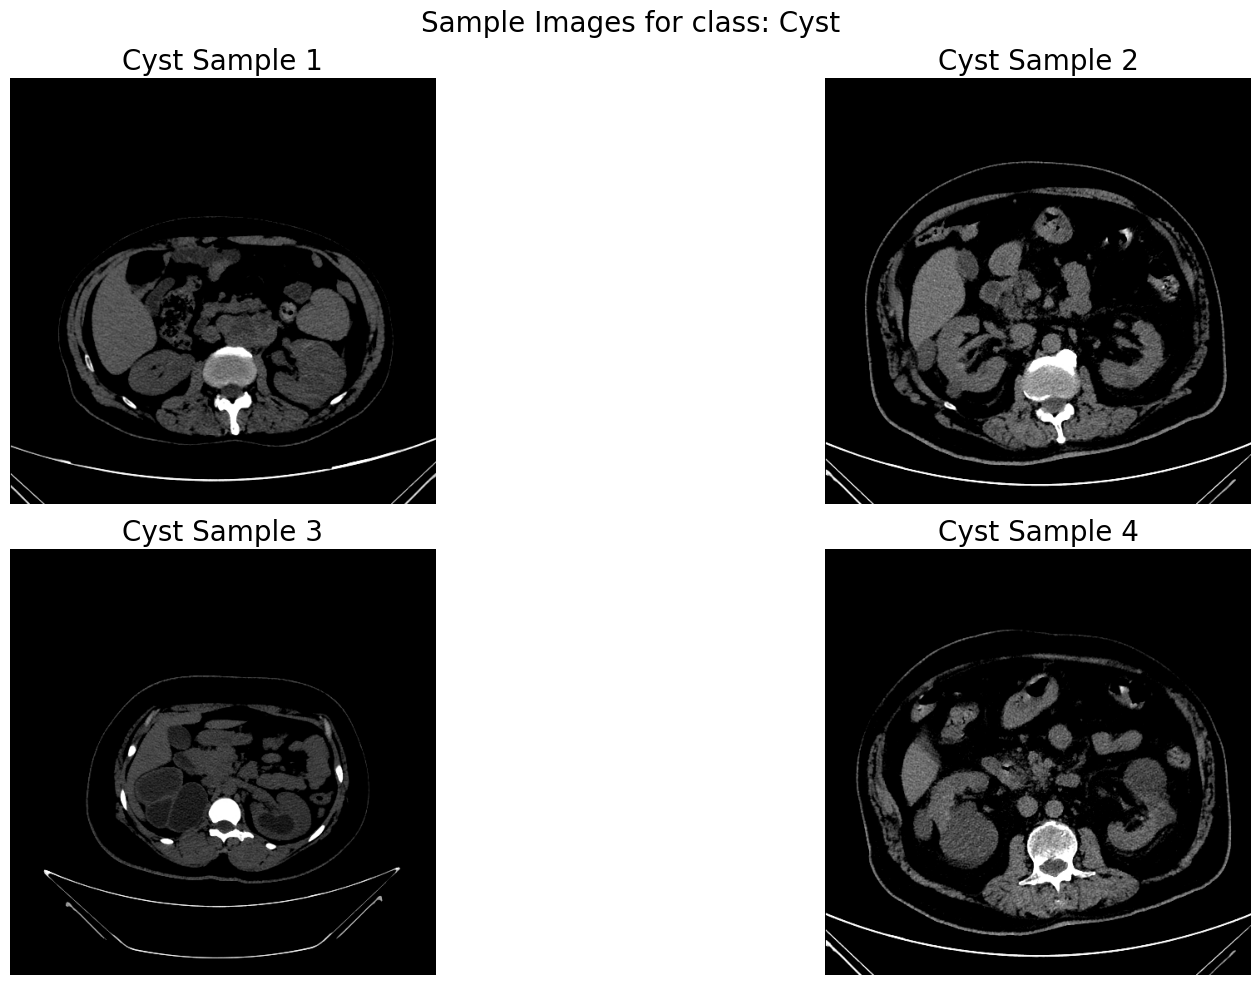

In [46]:
class_name = "Cyst"               
samples_per_class = 4
loaded_images = []
class_folder = os.path.join(dataset_path, class_name)
images = os.listdir(class_folder)
sample_images = random.sample(images, min(samples_per_class, len(images)))
c=2
r = (len(sample_images) + c - 1) // c
plt.figure(figsize=(20, 5*r))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    loaded_images.append(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.subplot(r, c, i+1)
    plt.plot(hist,)
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.xlim([0, 256])
    plt.xticks([])
    plt.yticks([])

plt.suptitle(f"Pixel Intensity Histograms for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5*r))
for i, img in enumerate(loaded_images):
    plt.subplot(r, c, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.axis('off')

plt.suptitle(f"Sample Images for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

The histograms are heavily concentrated toward the lower intensity range, indicating that most pixels are dark, which is consistent with the low mean pixel intensity observed for the Cyst class.

### Normal

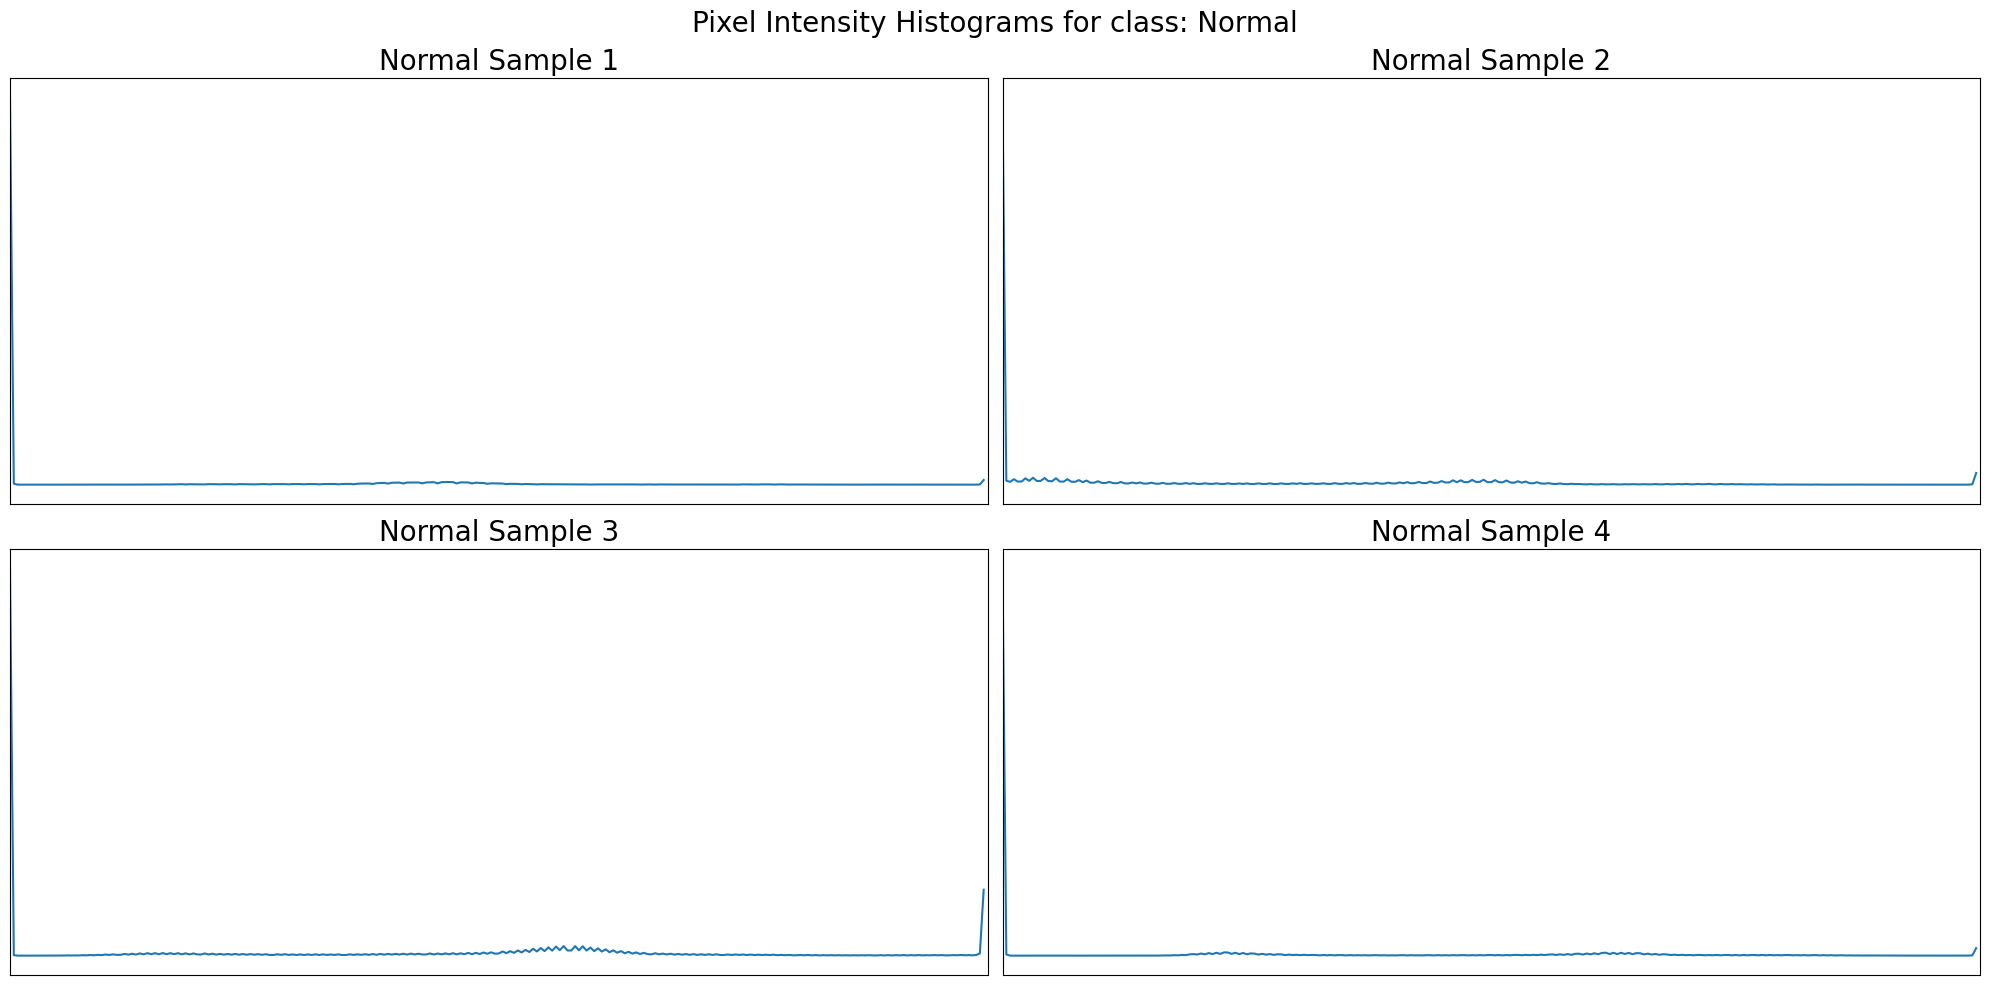

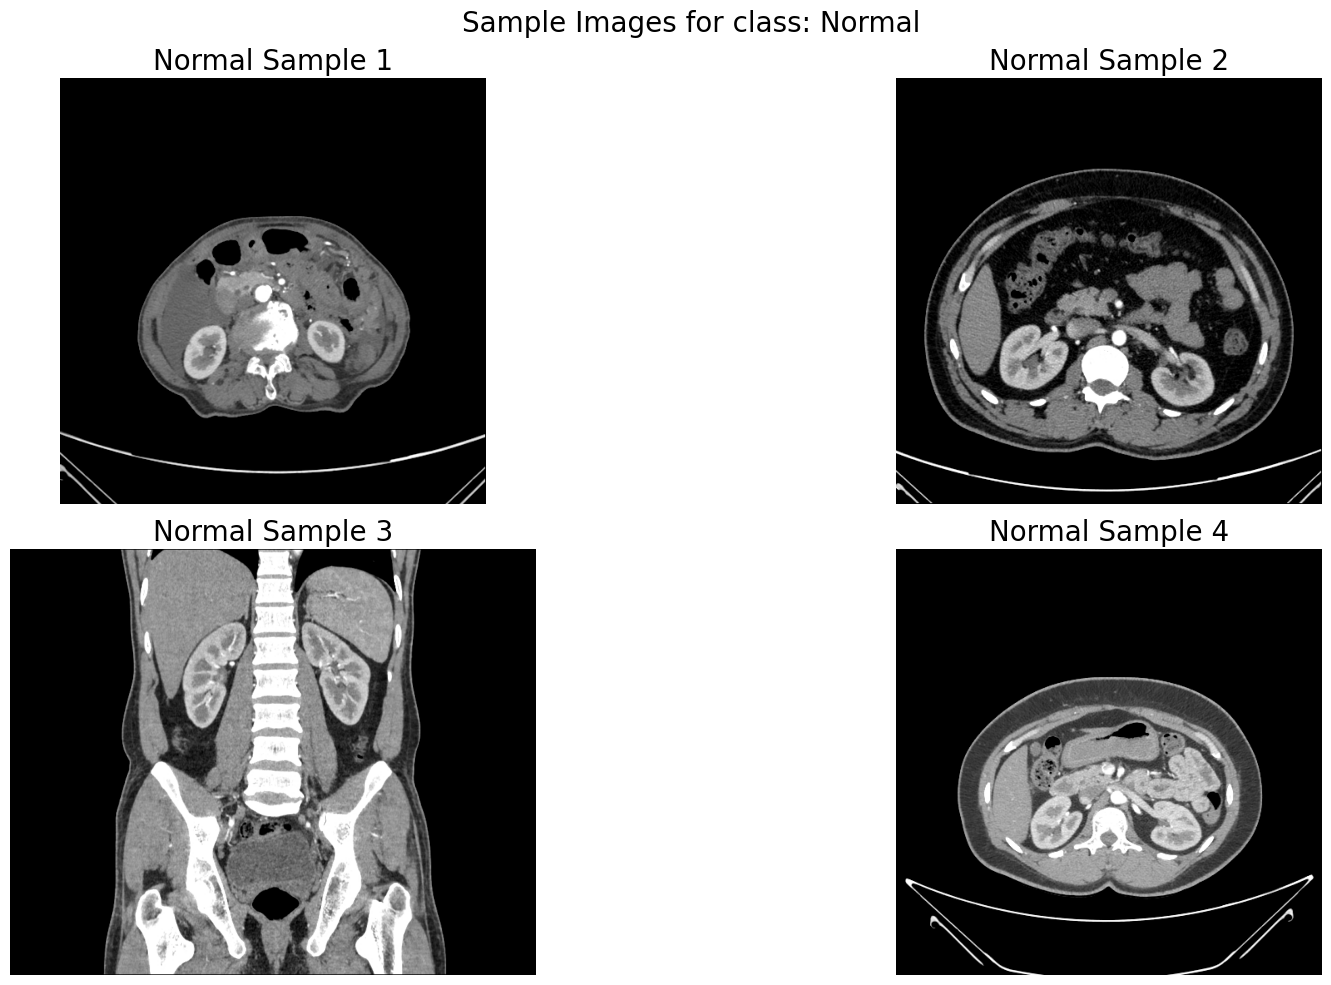

In [47]:
class_name = "Normal"               
samples_per_class = 4
loaded_images = []
class_folder = os.path.join(dataset_path, class_name)
images = os.listdir(class_folder)
sample_images = random.sample(images, min(samples_per_class, len(images)))
c=2
r = (len(sample_images) + c - 1) // c
plt.figure(figsize=(20, 5*r))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    loaded_images.append(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.subplot(r, c, i+1)
    plt.plot(hist,)
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.xlim([0, 256])
    plt.xticks([])
    plt.yticks([])

plt.suptitle(f"Pixel Intensity Histograms for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5*r))
for i, img in enumerate(loaded_images):
    plt.subplot(r, c, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.axis('off')

plt.suptitle(f"Sample Images for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

The pixel intensity histograms for the Normal class show a relatively broad and brighter distribution with consistent patterns across samples, indicating higher average pixel intensities and stable intra-class characteristics compared to abnormal classes.

### Stone 

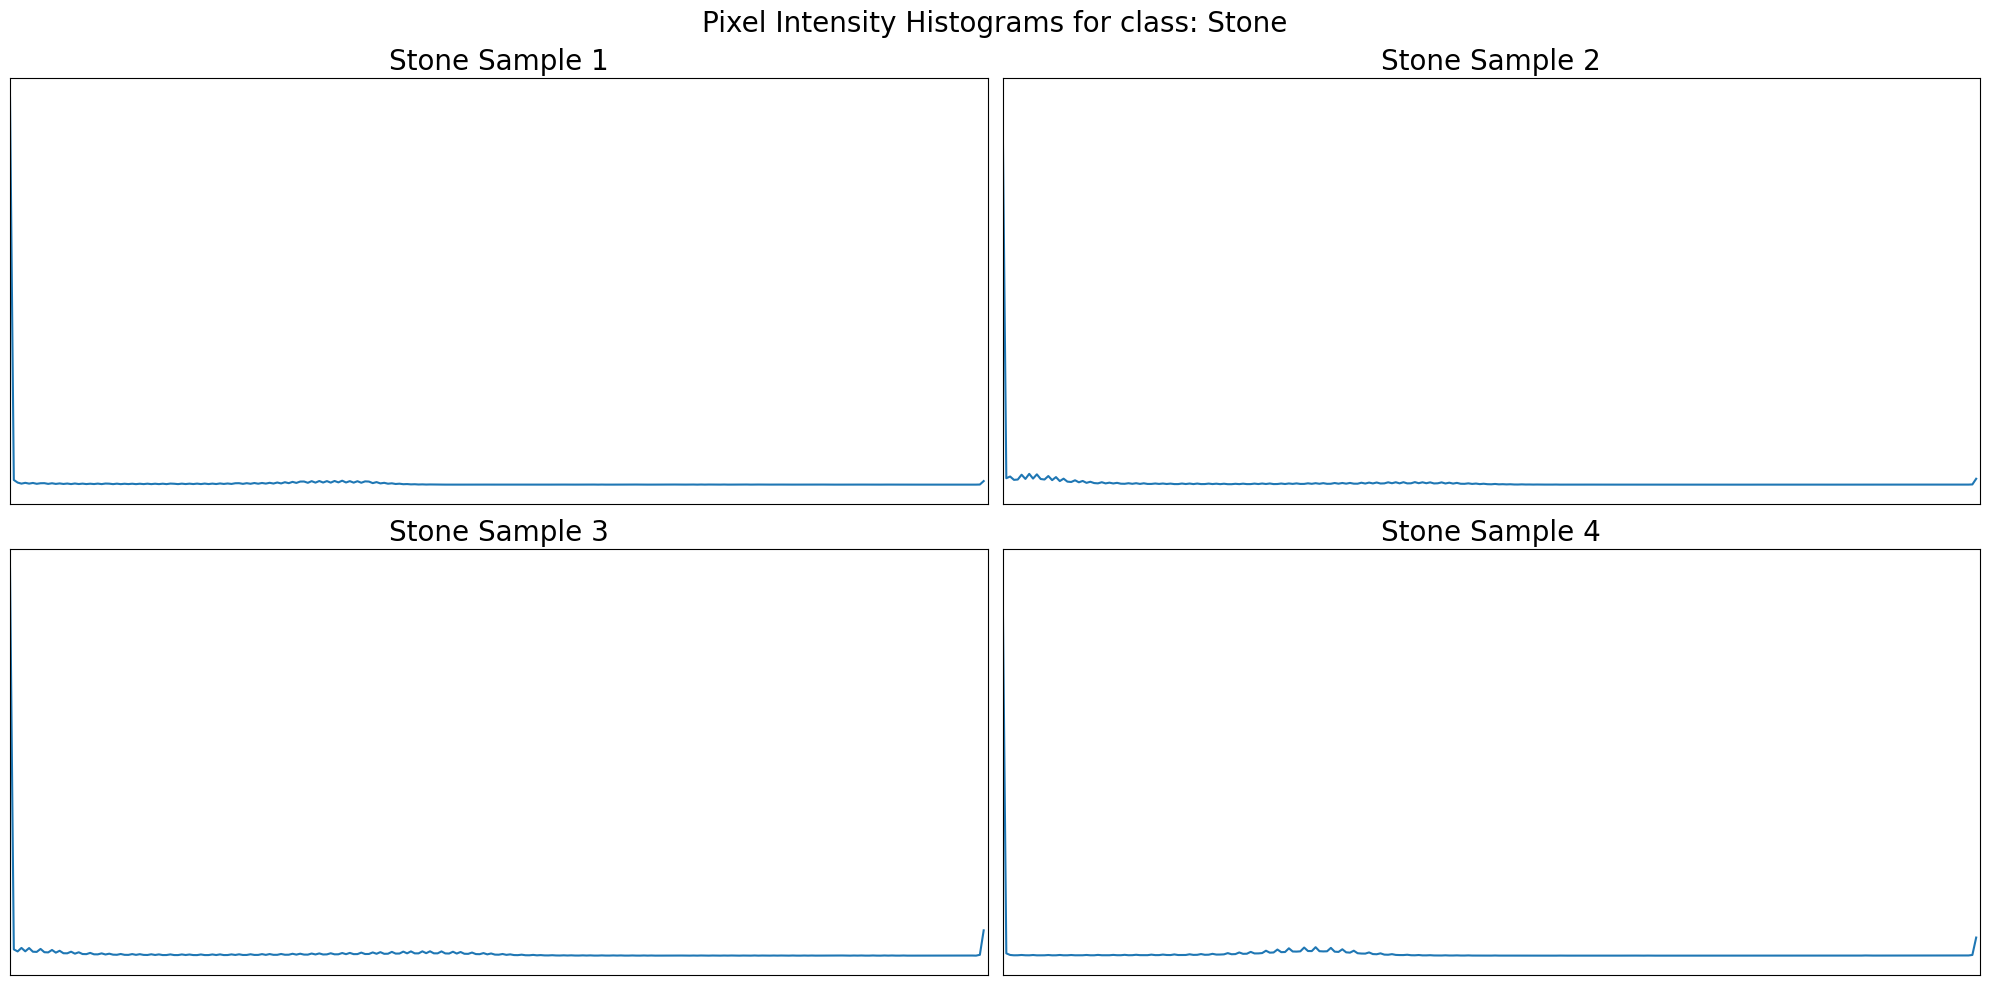

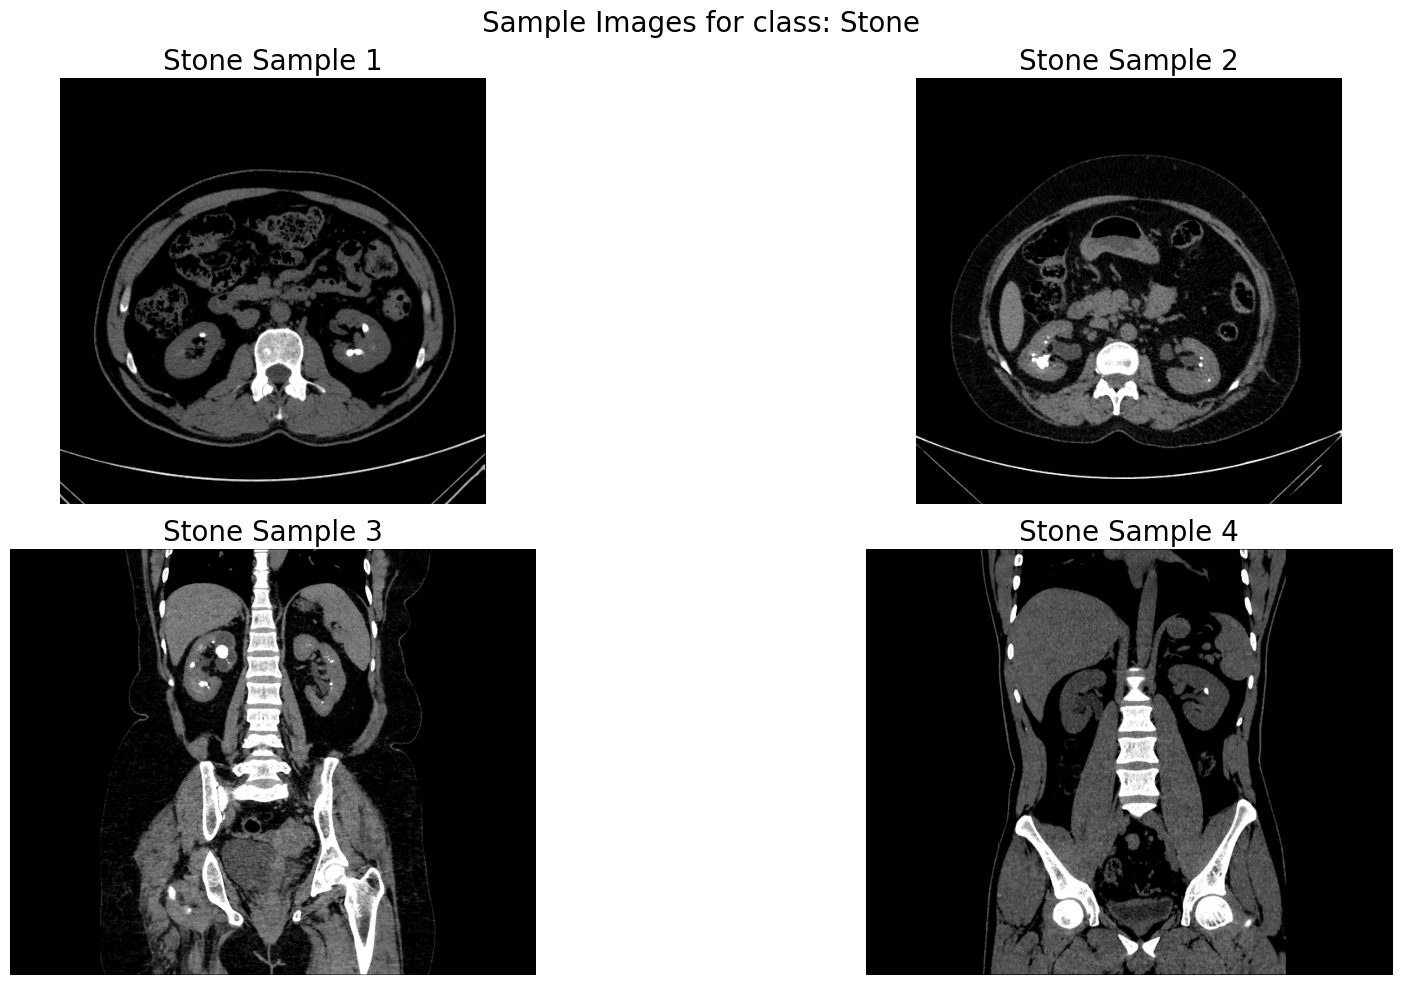

In [48]:
class_name = "Stone"               
samples_per_class = 4
loaded_images = []
class_folder = os.path.join(dataset_path, class_name)
images = os.listdir(class_folder)
sample_images = random.sample(images, min(samples_per_class, len(images)))
c=2
r = (len(sample_images) + c - 1) // c
plt.figure(figsize=(20, 5*r))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    loaded_images.append(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.subplot(r, c, i+1)
    plt.plot(hist,)
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.xlim([0, 256])
    plt.xticks([])
    plt.yticks([])

plt.suptitle(f"Pixel Intensity Histograms for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5*r))
for i, img in enumerate(loaded_images):
    plt.subplot(r, c, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.axis('off')

plt.suptitle(f"Sample Images for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

The histograms are heavily concentrated toward the lower intensity range, indicating that most pixels are dark, which is consistent with the low mean pixel intensity observed for the Stone class.

### Tumor

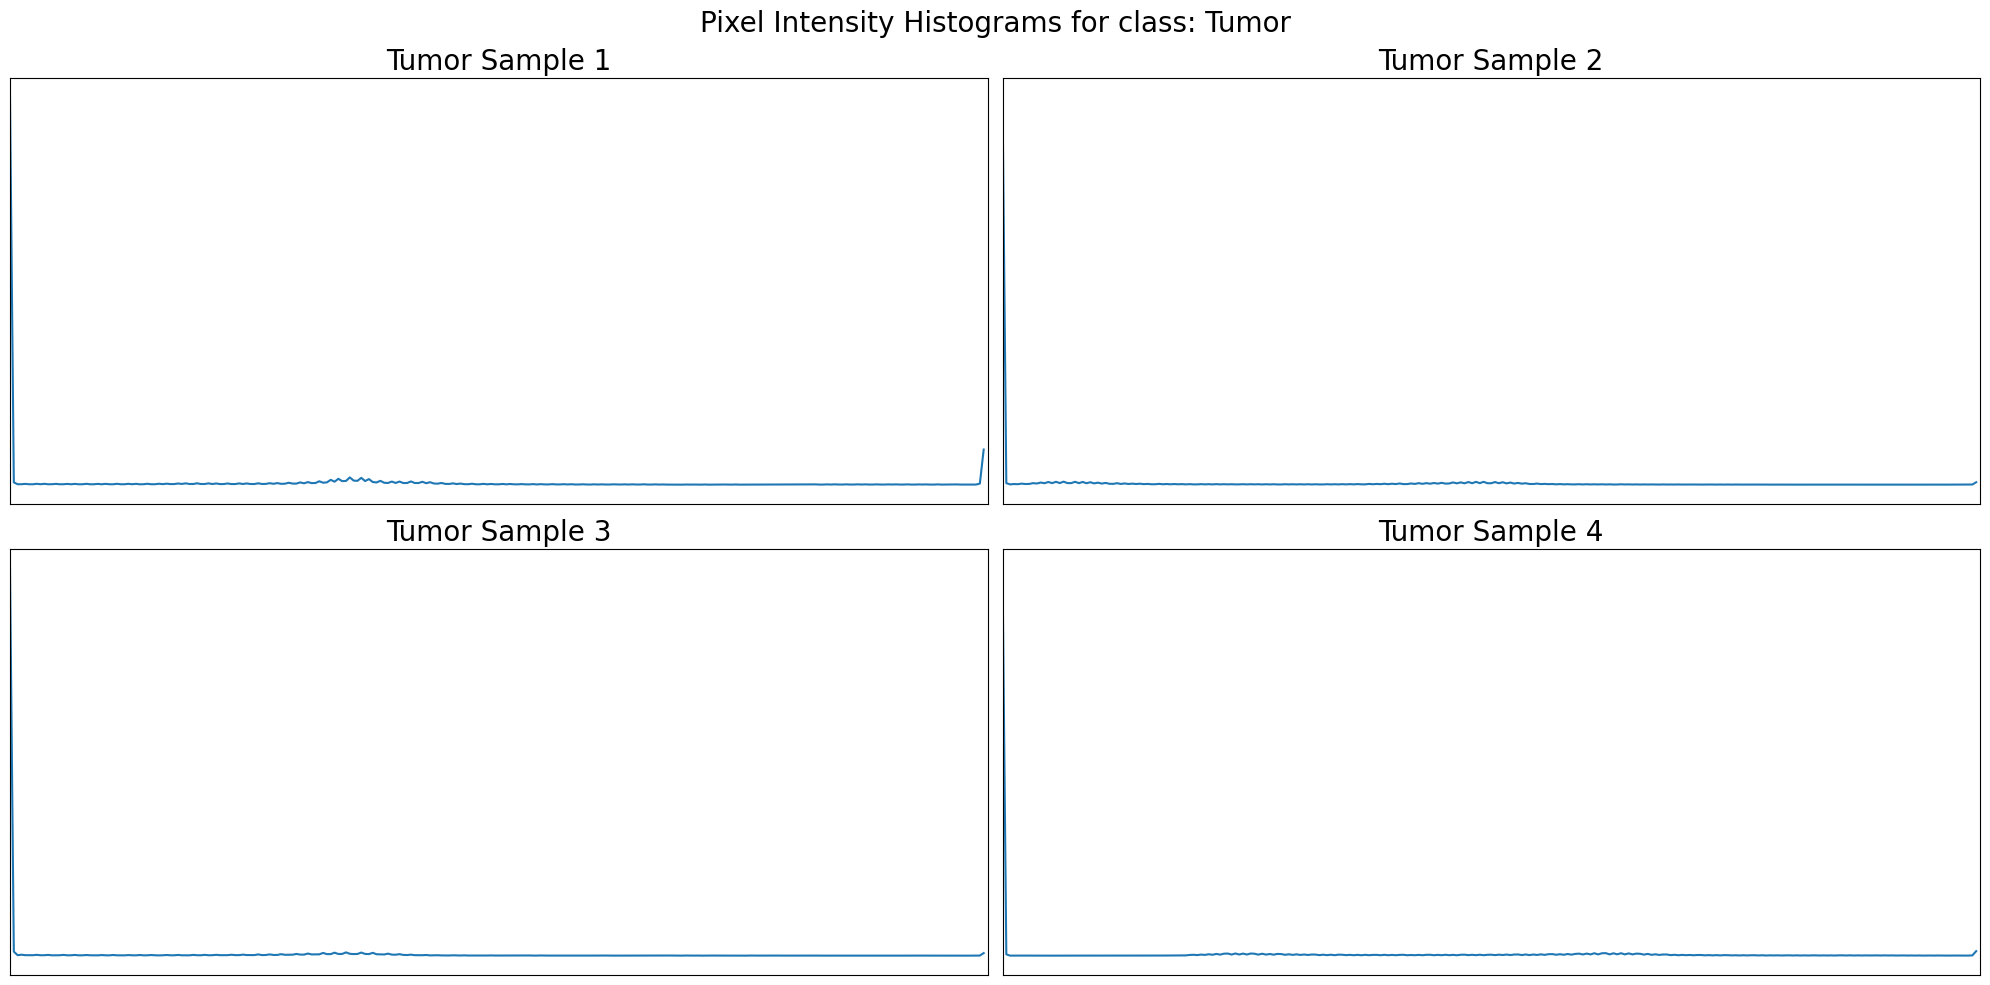

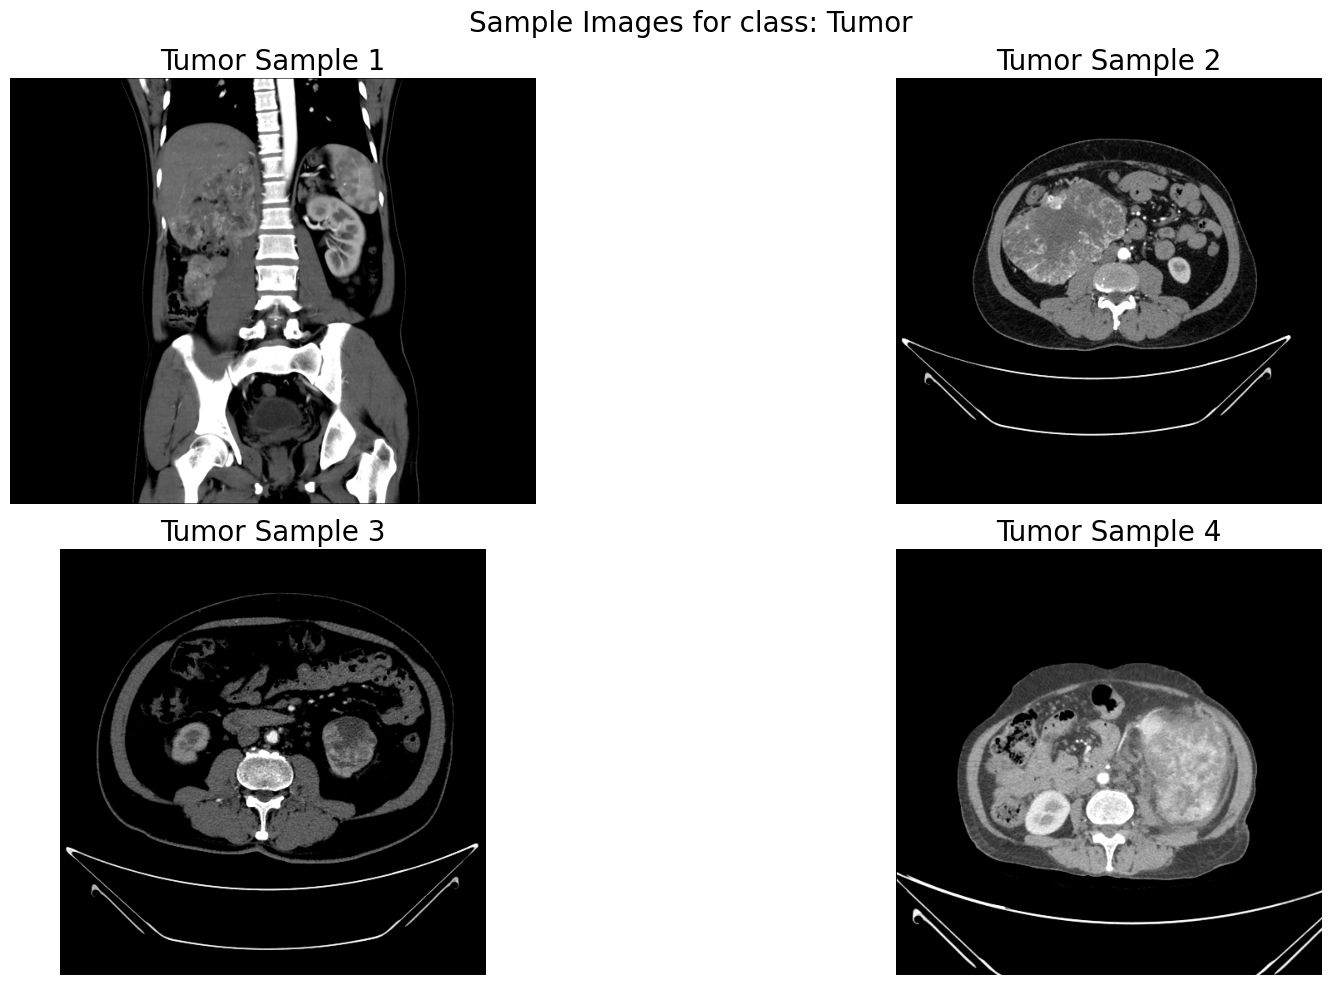

In [45]:
class_name = "Tumor"    
loaded_images = []           
samples_per_class = 4
class_folder = os.path.join(dataset_path, class_name)
images = os.listdir(class_folder)
sample_images = random.sample(images, min(samples_per_class, len(images)))
c=2
r = (len(sample_images) + c - 1) // c
plt.figure(figsize=(20, 5*r))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(class_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    loaded_images.append(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    plt.subplot(r, c, i+1)
    plt.plot(hist,)
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.xlim([0, 256])
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle(f"Pixel Intensity Histograms for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5*r))
for i, img in enumerate(loaded_images):
    plt.subplot(r, c, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_name} Sample {i+1}", fontsize=20)
    plt.axis('off')

plt.suptitle(f"Sample Images for class: {class_name}", fontsize=20)
plt.tight_layout()
plt.show()


# Channel Wise EDA

In [3]:
def channel_stats(class_name):
    path = os.path.join(dataset_path, class_name)
    r_means, g_means, b_means = [], [], []
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        r_means.append(np.mean(img[:,:,0]))
        g_means.append(np.mean(img[:,:,1]))
        b_means.append(np.mean(img[:,:,2]))

    print(f"Class: {class_name}")
    print("R mean:", np.mean(r_means))
    print("G mean:", np.mean(g_means))
    print("B mean:", np.mean(b_means))

classes=['Normal','Cyst','Tumor','Stone']

for c in classes:
    channel_stats(c)


Class: Normal
R mean: 44.657624732048134
G mean: 44.657624732048134
B mean: 44.657624732048134
Class: Cyst
R mean: 26.448579182442128
G mean: 26.448579182442128
B mean: 26.448579182442128
Class: Tumor
R mean: 36.28489292709483
G mean: 36.28489292709483
B mean: 36.28489292709483
Class: Stone
R mean: 35.39585337930378
G mean: 35.39585337930378
B mean: 35.39585337930378


Here the channel wise EDA shows that the RGB is same for per class which means that the dataset is grayscale. This suggest that color fetures are not informative. After this, we avoid the RGB features and do not need to use the per-channel normalization. Therefore, color information is not contributing to class discrimination; the model will rely on texture, shape, and intensity patterns instead.